GoingDeeper 3.  Class_Activation_Map
---------------------------------------------------------
## 프로젝트 목표

- CAM, Grad_CAM 구현 및 시각화
- IOU, Bounding Box 활용

### 0. 모듈 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import os

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. 데이터 불러오기

In [2]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files = True,
    with_info = True,
)
BATCH_SIZE = 32

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


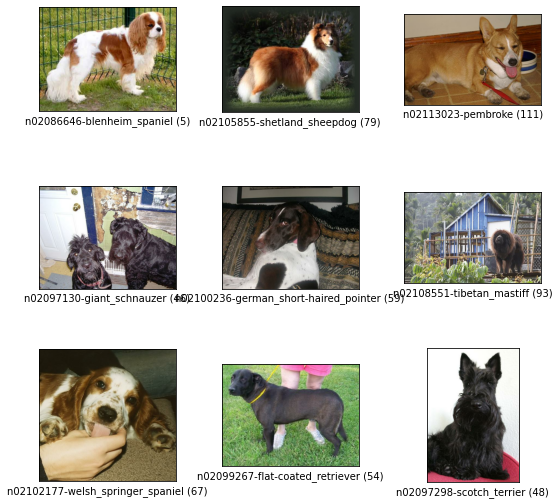

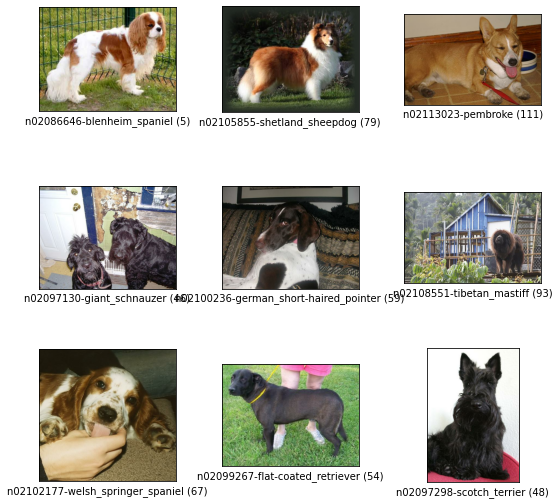

In [3]:
tfds.show_examples(ds_train,ds_info)

### 2. 전처리 함수 및 시각화 함수

In [4]:
def normalize_and_resize_image(input):
    image = tf.image.resize(input['image'],[224,224])
    input['image'] = tf.cast(image,tf.float32)/255.
    return input['image'],input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCH_SIZE):
    ds = ds.map(normalize_and_resize_image,num_parallel_calls = 2)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

### 3-1. 모델 정의

In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg'
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


In [6]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
    image,label = input

### 3-2. 모델 훈련

In [7]:
tf.random.set_seed(1103)
cam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [8]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=25,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 369s 874ms/step - loss: 3.5427 - accuracy: 0.2406 - val_loss: 4.9187 - val_accuracy: 0.0050
Epoch 2/25
375/375 [==============================] - 314s 838ms/step - loss: 1.0050 - accuracy: 0.7356 - val_loss: 2.9343 - val_accuracy: 0.2847
Epoch 3/25
375/375 [==============================] - 314s 837ms/step - loss: 0.4293 - accuracy: 0.9057 - val_loss: 1.0713 - val_accuracy: 0.6851
Epoch 4/25
375/375 [==============================] - 314s 837ms/step - loss: 0.1942 - accuracy: 0.9704 - val_loss: 0.9170 - val_accuracy: 0.7275
Epoch 5/25
375/375 [==============================] - 314s 837ms/step - loss: 0.0838 - accuracy: 0.9937 - val_loss: 0.9344 - val_accuracy: 0.7278
Epoch 6/25
375/375 [==============================] - 314s 837ms/step - loss: 0.0736 - accuracy: 0.9943 - val_loss: 0.9350 - val_accuracy: 0.7305
Epoch 7/25
375/375 [==============================] - 314s 839ms/step - loss: 0.0379 - accuracy: 0.9991 - val_loss: 0.9272 -

In [10]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 4-1 CAM 구현

In [12]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor,class_idx = normalize_and_resize_image(item)

    cam_model = tf.keras.models.Model([model.inputs],[model.layers[-3].output,model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))

    conv_outputs = conv_outputs[0,:,:,:]
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
    for i,w in enumerate(class_weights[:,class_idx]):
        cam_image += w * conv_outputs[:,:,i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image,(width,height))
    return cam_image

### 4-2 CAM Visualization

In [15]:
def visual_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [13]:
item = get_one(ds_test)
cam_image = generate_cam(cam_model,item)

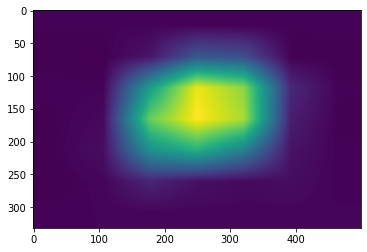

In [14]:
plt.imshow(cam_image)
plt.show()

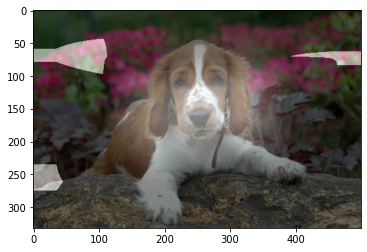

In [16]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis= -1).astype(np.uint8)

blended_image = visual_cam_on_image(cam_image_3channel,origin_image)
plt.imshow(blended_image)
plt.show()

### 4-3. Gradient_CAM 구현

In [28]:
def generate_grad_cam(model,activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor,class_idx = normalize_and_resize_image(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))
        loss = pred[:,class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss,conv_output)[0]

    weights = np.mean(grad_val,axis=(0,1))
    grad_cam_image = np.zeros(dtype= np.float32, shape= conv_output.shape[0:2])

    for i,w in enumerate(weights):
        grad_cam_image += w * output[:,:,i]

    grad_cam_image /= np.max(cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(cam_image,(width,height))
    return cam_image

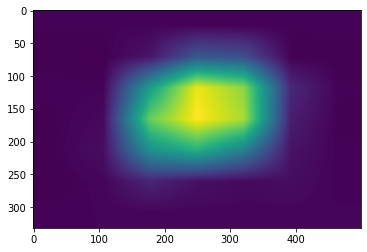

In [29]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

### 4-4 Bounding BOX , IOU 구현

In [34]:
def get_bbox(cam_image,score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

def rect_to_minmax(rect,image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

def get_iou(boxA, boxB):
    y_min = max(boxA[0],boxB[0])
    x_min = max(boxA[1],boxB[1])
    y_max = min(boxA[2],boxB[2])
    x_max = min(boxA[3],boxB[3])

    interArea = max(0 , x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou
rect = get_bbox(cam_image)

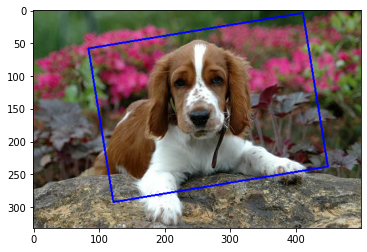

In [32]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

In [36]:
get_iou(pred_bbox, item['objects']['bbox'][0])


0.6767573830141224

### 회고
- 기존의 블랙박스로 생각했던 딥러닝 및 머신러닝이 시각화를 통해 어떻게 구동되는지를 확인할 수 있었던 계기가 되었다.
- 정말 이 노드를 이해하는데 다른 노드보다 한참 걸렸다, 생각했던것 보다 개념이해까지 많은 시간이 걸린다.
- 이번 노드는 나중에 프로젝트 할 때도 어떻게 돌아갔는지에 대해 설명할 때 도움이 될 것 같다.